# Summary of key observations

### Note: The separate SQL notebook contains the code for generating the summary csvs we use for Python analysis below. We also have a general exploratory analysis notebook for analysis of individual variables.

## Observation 1: Missing Property Types pose challenges to our analysis
We wanted to focus our analysis on residential sales, but we noticed there were 382446 rows out of 1097629 where the propertytype was blank. 
```
select count(*) from realestate20012022 where propertytype = ''
```
![no_property_type.png](no_property_type.png)

There were also multiple sales of $0 which are likely garbage values.

```
select count(*) from realestate20012022 where saleamount = 0
```
![saleamount_0.png](saleamount_0.png)

As a reasonable metric we used the 1st percentile sale amount of $10,000 as a cutoff for removing outliers before generating the summary csv
```
select
	PERCENTILE_CONT(0.01) WITHIN GROUP (ORDER BY saleamount) OVER () AS p1
from realestate20012022
where propertytype in ('Residential', 'Condo', 'Four Family', 'Single Family', 'Three Family', 'Two Family', '')
```
![percentile_1](percentile_1.png)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We load our summary dataset, which joins the real estate and municipal data from 2019.
We also load just the real estate data to explore housing metrics going back to 2001, as explained in the SQL notebook.

In [8]:
raw_data = pd.read_csv("cse4705_summary_data.csv")
print(raw_data.shape)

(812, 47)


In [9]:
corr_matrix = raw_data.corr(numeric_only=True)

In [10]:
raw_realestate_data = pd.read_csv("cse4705_realestate_data.csv")

## Observation 2: The sales ratio (assessed value / sale price) has gone down significantly post-COVID across municipalities, indicating that property assessments have not kept pace with rapid increases in price.
We plot the median sales ratio below for all municipalities in the last 5 years. 

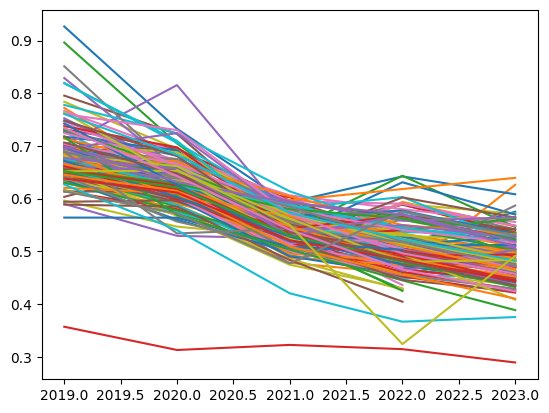

In [11]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
towns = raw_data['town'].unique()
for town in towns:
    temp = raw_data.loc[raw_data['town'] == town]
    ax1.plot(temp['year'], temp['median_sales_ratio'])

The correlation between year and sales ratio is also around -0.8, further supporting a significant and consistent trend.

In [12]:
corr_matrix[['year', 'median_sales_ratio']]

,year,median_sales_ratio
year,1.000000,-0.802375
count,-0.103065,-0.045603
avg_sale_price,0.152355,-0.039605
sale_price_q1,0.257865,-0.108183
median_sale_price,0.220036,-0.065716
sale_price_q3,0.182308,-0.035906
avg_sales_ratio,-0.303937,0.325833
sales_ratio_q1,-0.795139,0.969250
median_sales_ratio,-0.802375,1.000000
sales_ratio_q3,-0.711457,0.891869


## Observation 3: Box plots show that although sale prices skew right overall in the state. Surprisingly, a line graph of normalized IQR shows the variation in housing prices has decreased overall in the past 5 years.



The quartiles for sale amounts of all sales is found using SQL:
```
select
	PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY saleamount) OVER () AS q1,
	PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY saleamount) OVER () AS q2,
	PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY saleamount) OVER () AS q3
from realestatecleaned
```
![saleamount_quartiles](saleamount_quartiles.png)

This suggests property sale amounts overall skew right, which makes sense intuitively as there will be houses which are much more expensive than the typical middle-class home.

We compare a normalized IQR for municipalities over time. Intuitively, one might expect that as all summary statistics of sales prices have been going up, we may see increased variance as the most expensive homes become even more expensive. However, we find that overall, they trended downwards, indicating that variation is decreasing. We can hypothesize that the most expensive houses can only become so expensive, while the average house still has room to go higher.

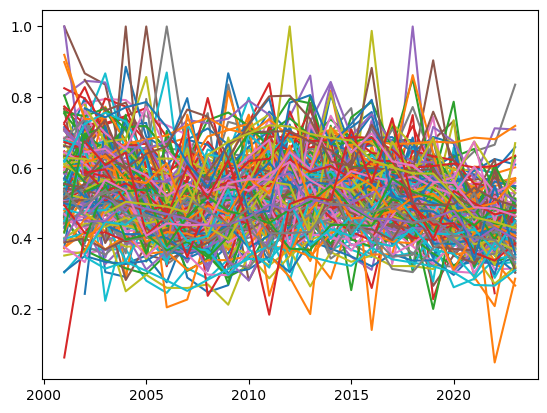

In [13]:
# raw_realestate_data["sale_price_IQRatio"] = raw_realestate_data["sale_price_q3"] / raw_realestate_data["sale_price_q1"]
raw_realestate_data["sale_price_IQRatio"] = (raw_realestate_data["sale_price_q3"] - raw_realestate_data["sale_price_q1"]) / raw_realestate_data["sale_price_q3"]
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
towns = raw_realestate_data['town'].unique()
for town in towns:
    temp = raw_realestate_data.loc[raw_realestate_data['town'] == town]
    ax2.plot(temp['year'], temp['sale_price_IQRatio'])

## Observation 4: Long term price trends in house prices deviate quite significantly between municipalities in Connecticut, but municipalities with the highest sale prices are more closely related

We graph the trend over time of median sale price for Milford and Darien, towns with very different income and wealth levels. The trends near the housing crash of 2009 and the post-Covid boom look similar, but there are still significant differences in trends, with Darien having a much more volatile period during the 2010's.

In [14]:
milford_realestate_data = raw_realestate_data.loc[raw_realestate_data['town'] == 'Milford']
darien_realestate_data = raw_realestate_data.loc[raw_realestate_data['town'] == 'Darien']
newcanaan_realestate_data = raw_realestate_data.loc[raw_realestate_data['town'] == 'New Canaan']
westport_realestate_data = raw_realestate_data.loc[raw_realestate_data['town'] == 'Westport']
greenwich_realestate_data = raw_realestate_data.loc[raw_realestate_data['town'] == 'Greenwich']

<Axes: xlabel='year'>

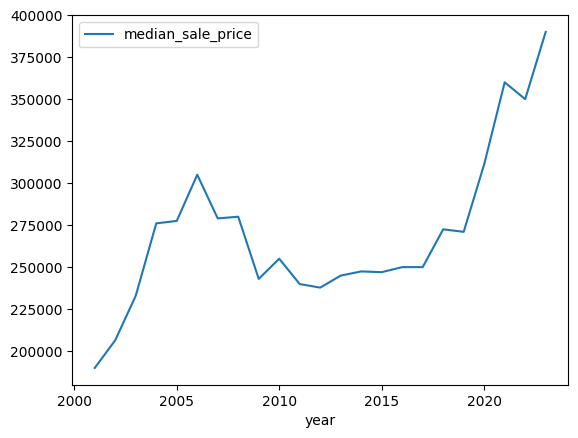

In [15]:
milford_realestate_data.plot.line(x='year', y='median_sale_price')

<Axes: xlabel='year'>

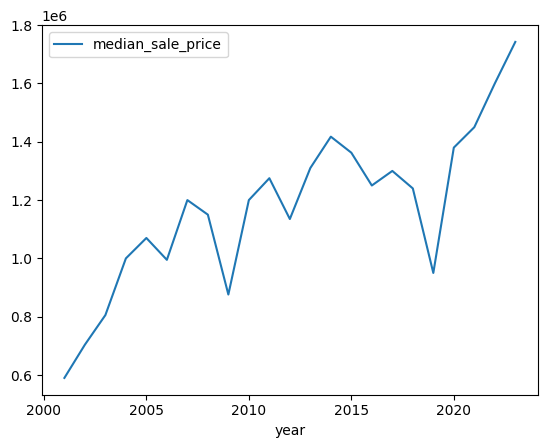

In [16]:
darien_realestate_data.plot.line(x='year', y='median_sale_price')

If we compare Darien with other municipalities in Fairfield County with very high real estate prices, the trends over time have similar features, with dips in 2009, 2012 and 2019.

<Axes: xlabel='year'>

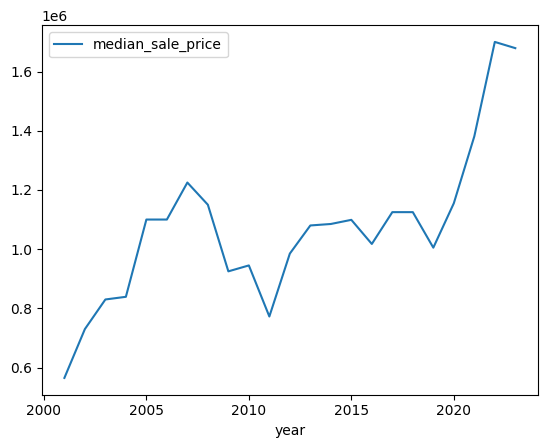

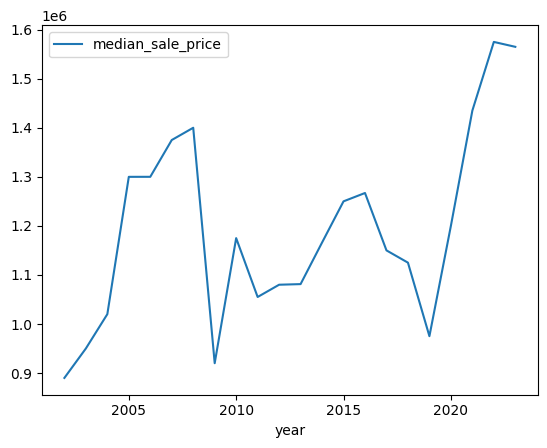

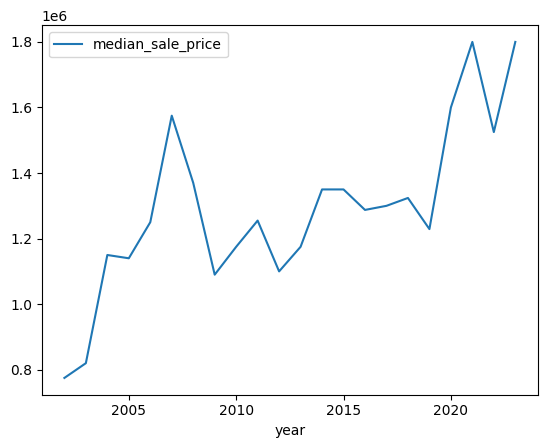

In [17]:
westport_realestate_data.plot.line(x='year', y='median_sale_price')
newcanaan_realestate_data.plot.line(x='year', y='median_sale_price')
greenwich_realestate_data.plot.line(x='year', y='median_sale_price')

If we look at correlation, for all municipalities in Connecticut, the correlation between year and median sale price is only 0.17 (not very significant at all), but if we take the 4 most expensive municipalities, it is near 0.7. Later in the semester, we may use clustering to find similar municipalities and identify relationships which are dependent on certain groupings, such as this case.

In [21]:
highest_sale_price = raw_realestate_data.loc[raw_realestate_data['town'].isin(['Westport', 'Darien', 'Greenwich', 'New Canaan'])]
raw_realestate_data.corr(numeric_only=True)
# highest_sale_price.corr(numeric_only=True)

,year,cnt_sales,avg_sale_price,sale_price_q1,median_sale_price,sale_price_q3,avg_sales_ratio,sales_ratio_q1,median_sales_ratio,sales_ratio_q3,avg_assessed_value,assessed_value_q1,median_assessed_value,assessed_value_q3,sale_price_IQRatio
year,1.000000,-0.021548,0.142625,0.193821,0.167680,0.114162,-0.029504,0.190334,0.049454,0.009828,0.162940,0.234952,0.186068,0.144055,-0.176716
cnt_sales,-0.021548,1.000000,0.070754,0.061901,0.058090,0.055821,-0.007170,-0.141230,-0.088729,-0.064769,0.039220,-0.006811,-0.004593,0.013409,-0.067906
avg_sale_price,0.142625,0.070754,1.000000,0.834996,0.868782,0.851683,0.015909,-0.074404,-0.053225,-0.067482,0.824177,0.770920,0.814455,0.814721,0.016092
sale_price_q1,0.193821,0.061901,0.834996,1.000000,0.970267,0.747247,0.010198,-0.062506,-0.079443,-0.104077,0.869908,0.901208,0.894392,0.850229,-0.241844
median_sale_price,0.167680,0.058090,0.868782,0.970267,1.000000,0.791376,0.018816,-0.070457,-0.072950,-0.090498,0.915429,0.893621,0.929369,0.904612,-0.057919
sale_price_q3,0.114162,0.055821,0.851683,0.747247,0.791376,1.000000,0.016368,-0.087152,-0.040458,-0.052987,0.754125,0.693049,0.744152,0.751435,0.095954
avg_sales_ratio,-0.029504,-0.007170,0.015909,0.010198,0.018816,0.016368,1.000000,-0.020143,-0.008951,-0.005991,0.016189,0.006109,0.015363,0.016113,0.020838
sales_ratio_q1,0.190334,-0.141230,-0.074404,-0.062506,-0.070457,-0.087152,-0.020143,1.000000,0.468425,0.353911,0.177818,0.266260,0.206897,0.155109,-0.022212
median_sales_ratio,0.049454,-0.088729,-0.053225,-0.079443,-0.072950,-0.040458,-0.008951,0.468425,1.000000,0.953012,0.140378,0.098406,0.085070,0.195534,0.099139
sales_ratio_q3,0.009828,-0.064769,-0.067482,-0.104077,-0.090498,-0.052987,-0.005991,0.353911,0.953012,1.000000,0.089115,0.026743,0.023178,0.147899,0.144476


## Observation #5: Hartford is an outlier with very low sales ratio consistently

In [23]:
town_median_sales_ratio = raw_data.groupby(['town', 'year'])['median_sales_ratio'].mean().unstack()

high_sales_ratio_threshold = 0.85
low_sales_ratio_threshold = 0.50

high_sales_ratio_towns = town_median_sales_ratio[(town_median_sales_ratio > high_sales_ratio_threshold).sum(axis=1) >= 5]

low_sales_ratio_towns = town_median_sales_ratio[(town_median_sales_ratio < low_sales_ratio_threshold).sum(axis=1) >= 5]

consistent_sales_ratio_towns = pd.concat([high_sales_ratio_towns, low_sales_ratio_towns])

print("Towns with Consistent High or Low Median Sales Ratios:")
print(consistent_sales_ratio_towns)

Towns with Consistent High or Low Median Sales Ratios:
year       2019    2020     2021    2022    2023
town                                            
Hartford  0.357  0.3129  0.32255  0.3145  0.2892


Note

Our high and low sales ratio thresholds are user defined.
With these thresholds, we find towns with a consistent high and low sales ratio

We find that the town of Hartford has a consistent low sales ratio (under 0.50 over consecutive 5 years). It is clearly an outlier

C:\Users\tomkm\AppData\Local\Temp\ipykernel_22824\419605172.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


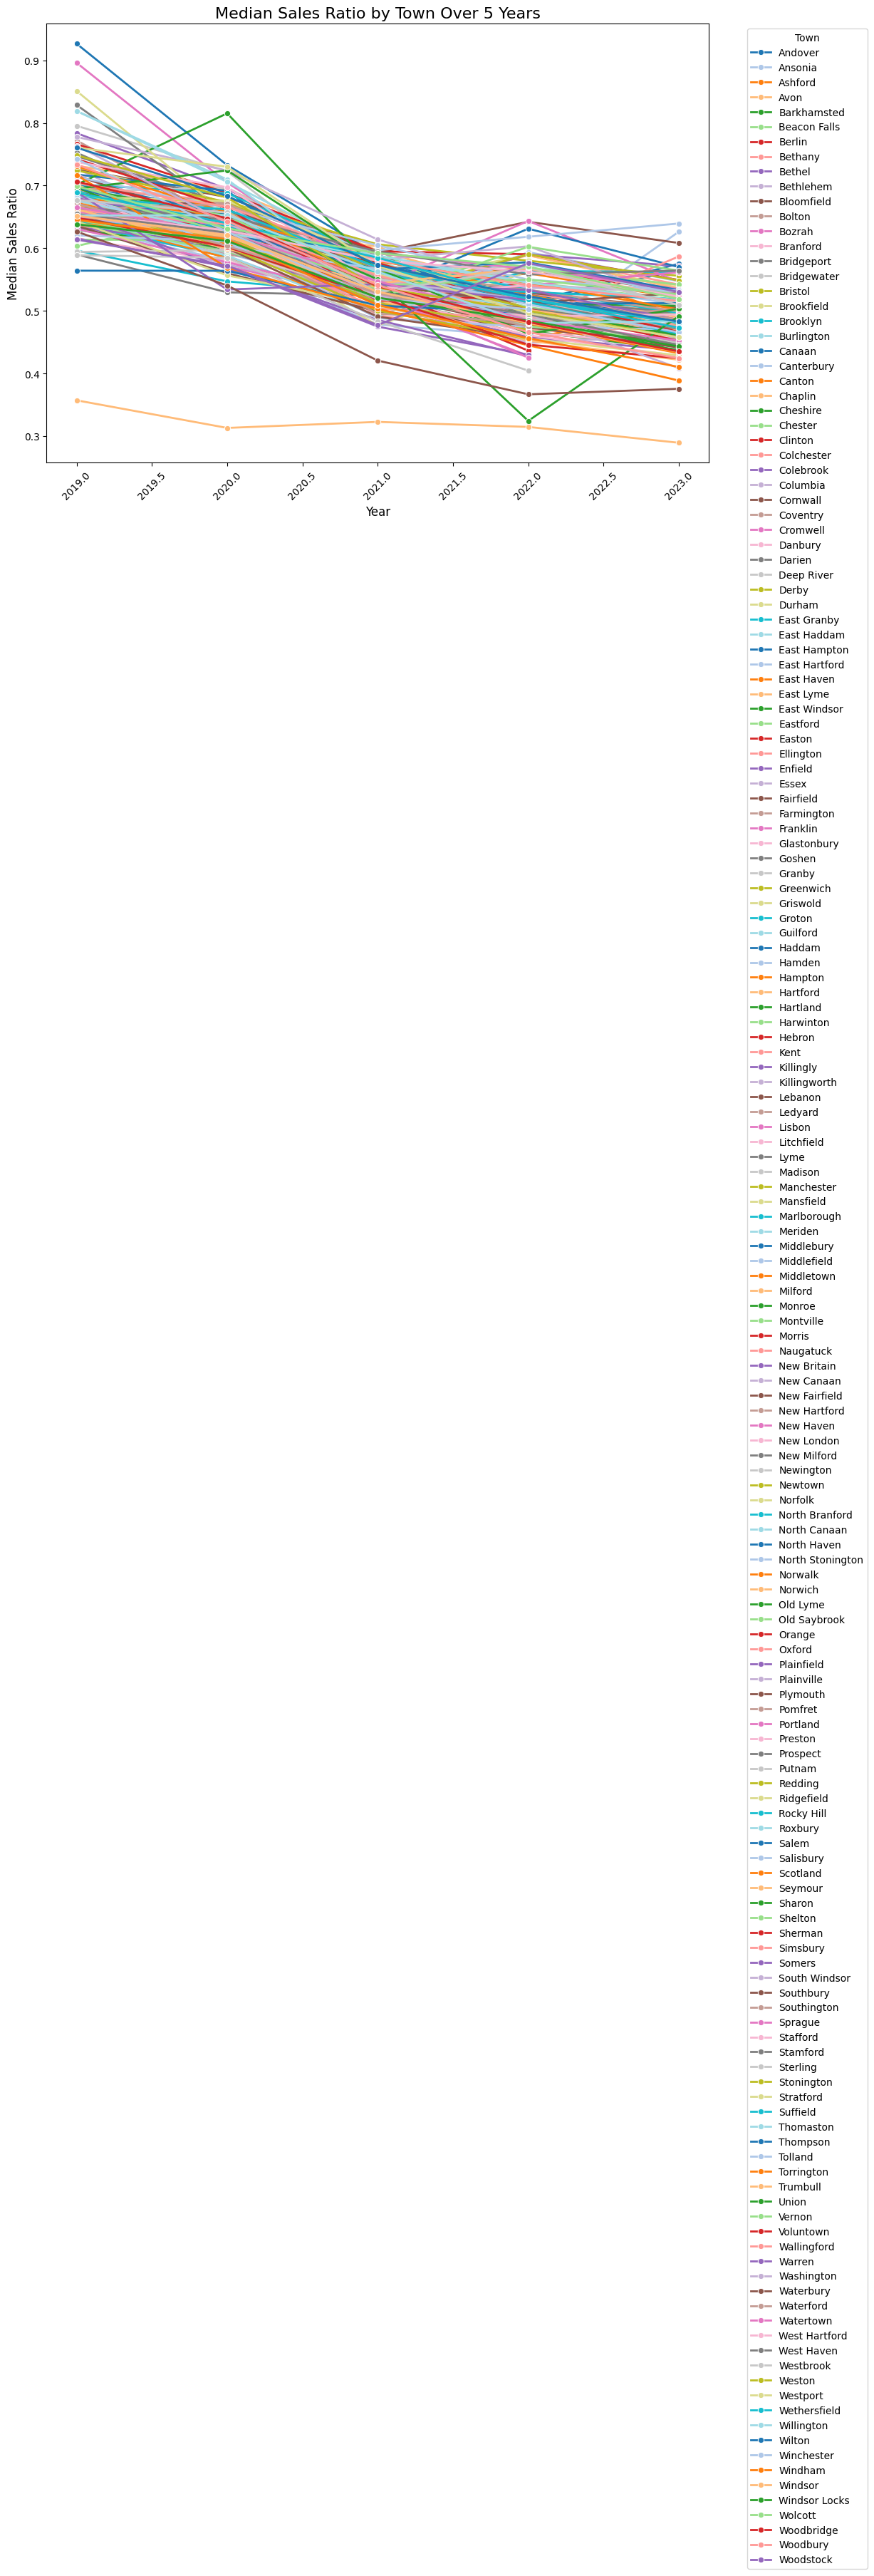

In [26]:
town_median_sales_ratio = raw_data.groupby(['town', 'year'])['median_sales_ratio'].mean().reset_index()

plt.figure(figsize=(12, 8))

# median sales ratio by year for each town
sns.lineplot(data=town_median_sales_ratio, x='year', y='median_sales_ratio', hue='town', marker='o', palette='tab20', linewidth=2)

plt.title('Median Sales Ratio by Town Over 5 Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Sales Ratio', fontsize=12)

plt.xticks(rotation=45)

plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

## Observation #6: Hartland is an outlier with very volatile sales ratio

In [27]:
town_median_sales_ratio = raw_data.groupby(['town', 'year'])['median_sales_ratio'].mean().reset_index()

town_median_sales_ratio = town_median_sales_ratio.sort_values(by=['town', 'year'])

# find the difference in median sales ratio for each town between consecutive years
town_median_sales_ratio['difference'] = town_median_sales_ratio.groupby('town')['median_sales_ratio'].diff()

# find towns where the absolute difference is greater than 0.25 between two years
volatile_towns = town_median_sales_ratio[town_median_sales_ratio['difference'].abs() > 0.25]

print("Towns with volatile median_sales_ratio:")
print(volatile_towns[['town', 'year', 'median_sales_ratio', 'difference']])

Towns with volatile median_sales_ratio:
         town  year  median_sales_ratio  difference
309  Hartland  2021             0.56125     -0.2542


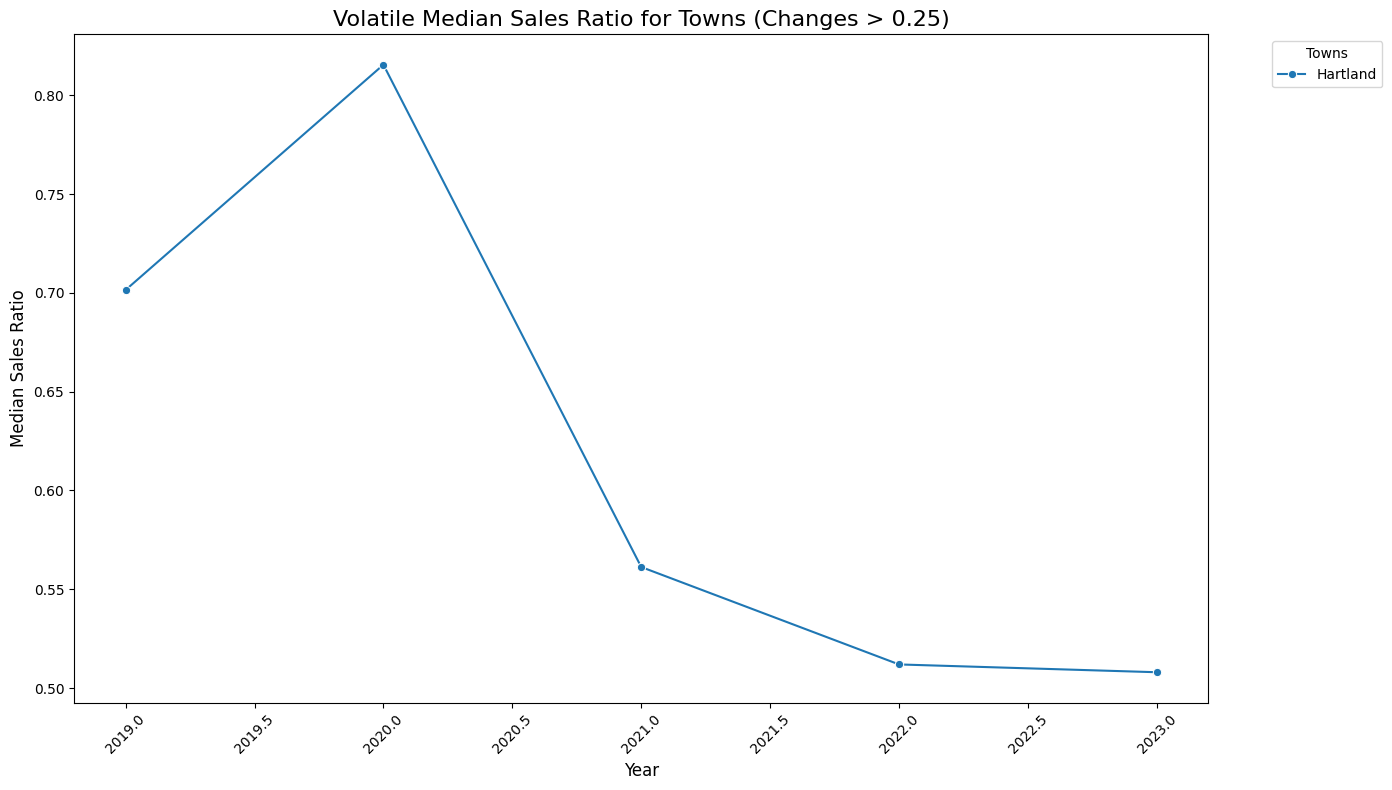

In [28]:
town_median_sales_ratio = raw_data.groupby(['town', 'year'])['median_sales_ratio'].mean().reset_index()

town_median_sales_ratio = town_median_sales_ratio.sort_values(by=['town', 'year'])

# find the difference in median sales ratio for each town between consecutive years
town_median_sales_ratio['difference'] = town_median_sales_ratio.groupby('town')['median_sales_ratio'].diff()

# find towns where the absolute difference is greater than 0.25 between two years
volatile_towns = town_median_sales_ratio[town_median_sales_ratio['difference'].abs() > 0.25]

volatile_town_list = volatile_towns['town'].unique()
plt.figure(figsize=(14, 8))

for town in volatile_town_list:
    volatile_town_data = town_median_sales_ratio[town_median_sales_ratio['town'] == town]
    sns.lineplot(data=volatile_town_data, x='year', y='median_sales_ratio', marker='o', label=town)

plt.title('Volatile Median Sales Ratio for Towns (Changes > 0.25)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Sales Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Towns', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()

It is clearly an outlier. This is likely cause by a huge update in assessed value around 2020-2021.